# Serie Temporal

https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15,6
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('datasets/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m') 
data = pd.read_csv('datasets/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse) 
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [7]:
ts['1949-01-01']

112

In [8]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

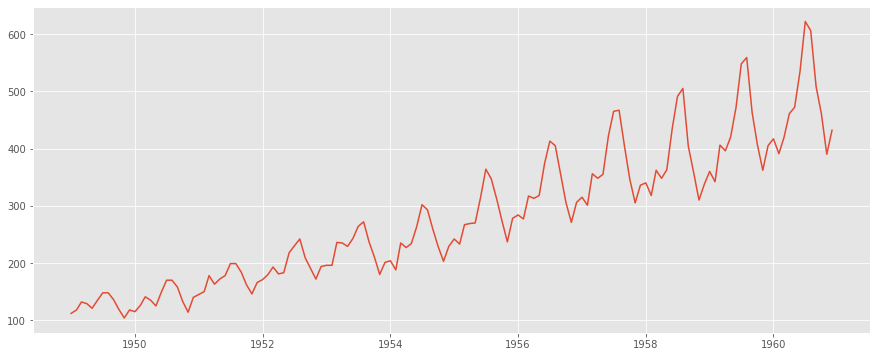

In [10]:
plt.plot(ts)

## Análise de série estacionaria.

A TS é dita estacionária se as suas propriedades estatísticas, tais como a média e variância permanecem constantes ao longo do tempo. Mas por que isso é importante? A maioria dos modelos TS trabalha com o pressuposto de que a TS é estacionária. Intuitivamente, podemos entender que se uma TS tem um comportamento particular ao longo de um tempo, há uma probabilidade muito elevada de que seguirá o mesmo comportamento no futuro. Além disso, as teorias relacionadas com séries estacionárias são mais maduras e mais fáceis de implementar, em comparação com séries não-estacionárias.

Estacionaridade (‘Stationarity’)  é definida usando critérios muito rigorosos. No entanto, para efeitos práticos, podemos assumir a série como estacionária se ela tiver propriedades estatísticas constantes ao longo do tempo. Ou seja, as seguintes:
Uma média constante
Uma variância constante
Uma autocovariância que não dependa do tempo

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    orig = plt.plot(timeseries, color = 'blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Média e Desvio padrão móveis')
    plt.show(block=False)

    print('Resultados do teste Dickety-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste Estatistico', 'p-value', '#Lags Used', 'Numero de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor crítico (%s)' % key] = value
    print(dfoutput)

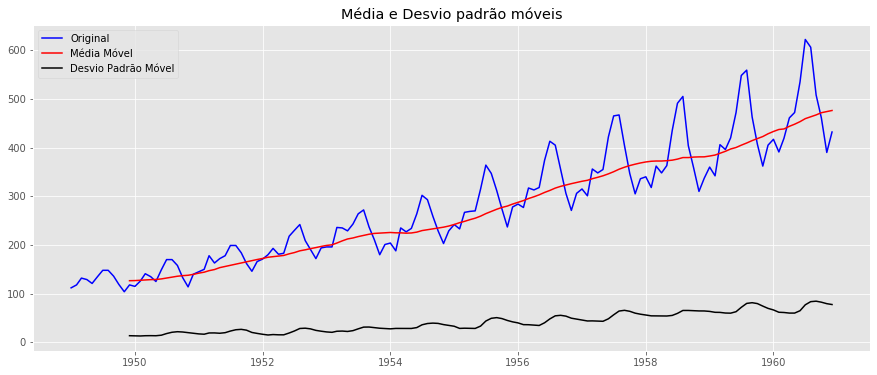

Resultados do teste Dickety-Fuller:
Teste Estatistico          0.815369
p-value                    0.991880
#Lags Used                13.000000
Numero de observações    130.000000
Valor crítico (1%)        -3.481682
Valor crítico (5%)        -2.884042
Valor crítico (10%)       -2.578770
dtype: float64


In [12]:
test_stationarity(ts)

Embora a variação de desvio padrão seja pequena, a média está claramente aumentando com o tempo e isto não é uma característica de série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Note que os valores assinalados devem ser comparados e não os valores absolutos.

### Como fazer TS estacionária ?

Embora o pressuposto de estacionaridade seja considerado em muitos modelos TS, quase nenhuma série temporal na prática é estacionária. Assim, os estatísticos descobriram maneiras de fazer séries estacionárias que vamos discutir agora. Na verdade, é quase impossível fazer uma série perfeitamente estacionária, mas tentaremos chegar o mais próximo possível.

Existem 2 principais razões por trás da não estacionaridade de uma TS:

 1. Tendência – média variante ao longo do tempo. Por exemplo, neste caso, vimos que, em média, o número de passageiros foi crescendo ao longo do tempo.
 
2. Sazonalidade – variações em períodos específicos. Por exemplo, as pessoas podem ter uma tendência a comprar carros em um mês em particular por causa de incremento de salário.
O princípio subjacente é o de modelar ou estimar a tendência e sazonalidade na série e remove-las da série para obter uma série estacionária. Em seguida, as técnicas de previsão estatística podem ser implementadas na série. A etapa final é converter os valores projetados para a escala original através da aplicação de restrições de tendência e de sazonalidade.
Nota: vamos discutir uma série de métodos. Alguns podem funcionar bem neste caso, outros não, pois a ideia é conseguir aplicar todos os métodos e não focar apenas o problema em questão.
Vamos começar a trabalhar na parte da tendência.


### Estimando e eliminando tendência

Uma das primeiras manobras para reduzir a tendência pode ser transformação. Por exemplo, neste caso, podemos ver claramente que existe uma tendência positiva significativa. Assim, podemos aplicar transformação que penaliza os valores maiores mais do que valores menores. Podemos tomar o logaritmo, a raiz quadrada, a raiz cúbica, etc.

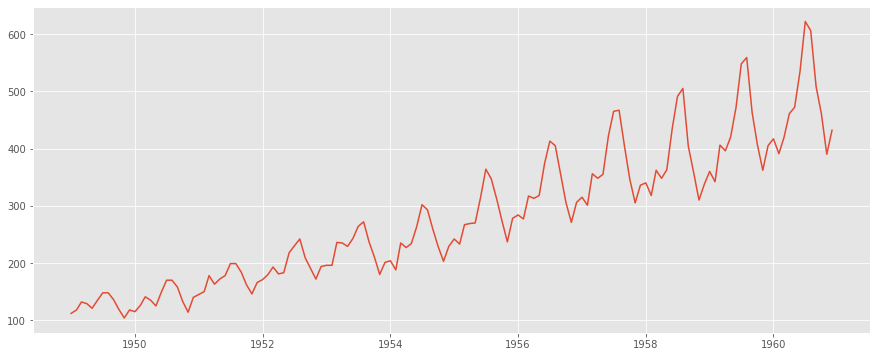

In [13]:
ts_log = np.log(ts)
plt.plot(ts)

Neste caso mais simples, é fácil ver para tendência futura nos dados. Mas não é muito intuitivo no caso de haver ruídos. Assim, podemos usar algumas técnicas para estimar ou modelar a tendência e, em seguida, removê-la da série. Podem haver muitas maneiras de fazer isso e algumas das mais comumente utilizadas são:

1- Agregação – usando a média para um período de tempo como médias semanais ou mensais

2- Suavização – usando médias moveis

3- Ajuste polinomial – encaixando um modelo de regressão

Vou usar suavização aqui, mas você deve tentar outras técnicas que podem funcionar para outros problemas. Suavização refere-se às estimativas contínuas, ou seja, considerando os últimos casos. Pode ser feito de várias maneiras, aqui vou discutir duas delas.

#### Média Movel

Consideramos a média de ‘K’ valores consecutivos, dependendo da frequência da série temporal.

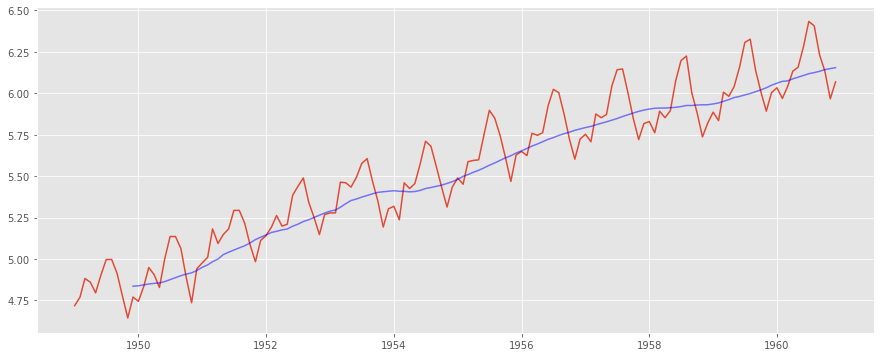

In [14]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='blue', alpha=0.5)
plt.show()

A linha azul mostra a média móvel. Iremos subtrair isso da série original. Note-se que uma vez que estamos tomando média dos últimos 12 valores, a média móvel não está definida para 11 primeiros valores. Isto pode ser observado como:

In [15]:
ts_log_moving_avg_diff  = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

Observe os primeiro 11 como sendo NaN. Vamos usar esses valores NaN para testar a estacionaridade.

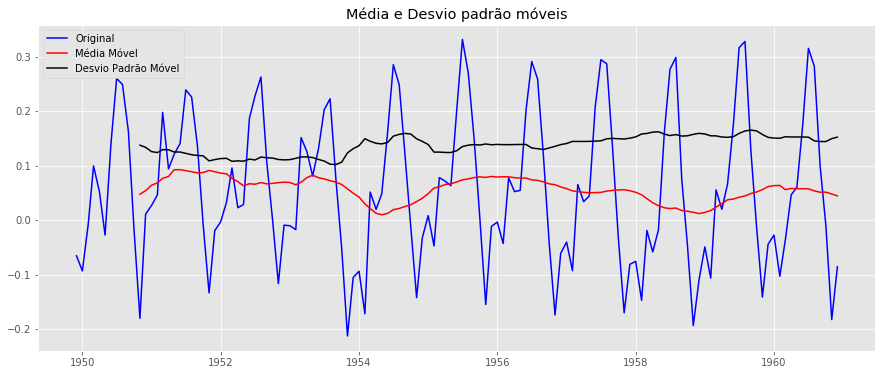

Resultados do teste Dickety-Fuller:
Teste Estatistico         -3.162908
p-value                    0.022235
#Lags Used                13.000000
Numero de observações    119.000000
Valor crítico (1%)        -3.486535
Valor crítico (5%)        -2.886151
Valor crítico (10%)       -2.579896
dtype: float64


In [16]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Parece uma série muito melhor. Os valores parecem ter variado um pouco, mas não há nenhuma tendência específica. Além disso, a estatística do teste é menor do que os valores críticos de 5% para que possamos dizer com 95% de confiança que esta é uma série estacionária.

Uma desvantagem dessa abordagem particular é que o período de tempo tem que ser rigorosamente definido. Nesse caso, podemos tomar médias anuais, mas em situações complexas como previsão de um preço das ações, é difícil chegar a um número. Então vamos usar uma “média móvel ponderada”, onde aos valores mais recentes é dado um peso maior. Não há muitas técnicas para atribuição de pesos. Uma popular é a média ponderada exponencial onde pesos são atribuídos a todos os valores anteriores com um fator de decaimento em movimento.

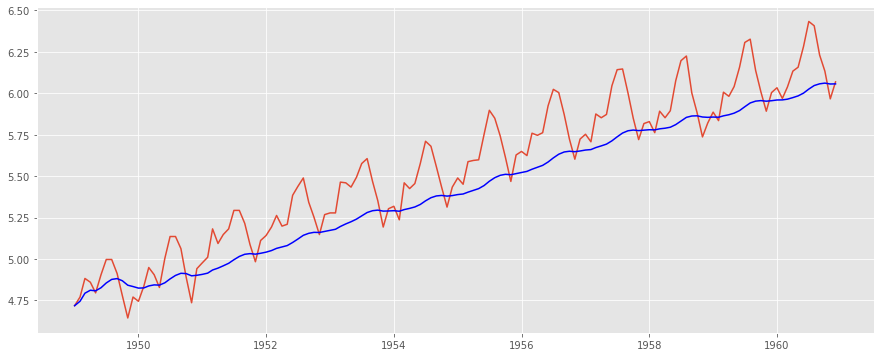

In [17]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color = 'blue')
plt.show()

Note que um parâmetro “halflife” é utilizado para definir o valor de decaimento exponencial. Esta é apenas uma suposição que depende em grande parte do domínio do negócio.
Outros parâmetros de capacidade e de centro de massa também podem ser utilizados para definir decaimento. Agora, vamos remover estas da série para obter a estacionaridade:

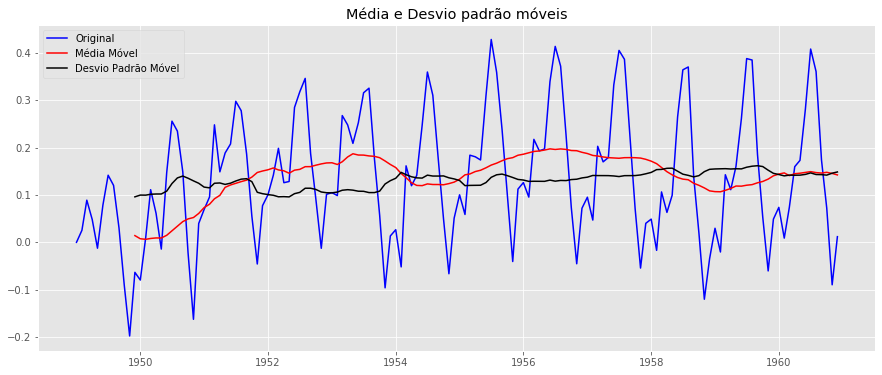

Resultados do teste Dickety-Fuller:
Teste Estatistico         -3.601262
p-value                    0.005737
#Lags Used                13.000000
Numero de observações    130.000000
Valor crítico (1%)        -3.481682
Valor crítico (5%)        -2.884042
Valor crítico (10%)       -2.578770
dtype: float64


In [18]:
ts_log_ewm_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewm_diff)

Esta TS tem variações ainda menores em média e desvio padrão em magnitude. Além disso, o teste estatístico é menor do que o valor crítico de 1%, o que é melhor do que no caso anterior. Note-se que, neste caso, não haverá valores faltantes, já que são dados pesos a todos os valores de saída. Por isso funciona mesmo sem valores anteriores.

## Eliminando tendência e sazonalidade

As técnicas simples de redução de tendência discutidos anteriormente não funcionam em todos os casos, particularmente naqueles com alta sazonalidade. Vamos discutir duas maneiras de remoção de tendência e de sazonalidade:

1- Diferenciação – tomando a diferença com um determinado intervalo de tempo.

2- Decomposição – modelando tanto a tendência quanto a sazonalidade e removendo-as a partir do modelo.

### Diferenciação

Um dos métodos mais comuns de lidar tanto com tendência quanto sazonalidade é a diferenciação. Nessa técnica, tomamos a diferença de observação em um instante particular com a do instante anterior. Isso funciona particularmente bem para estacionaridade crescente. Diferenciação de primeira ordem pode ser feito em pandas com:

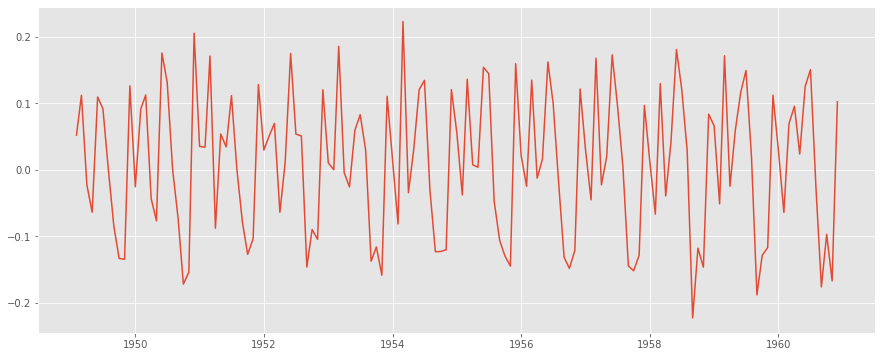

In [19]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

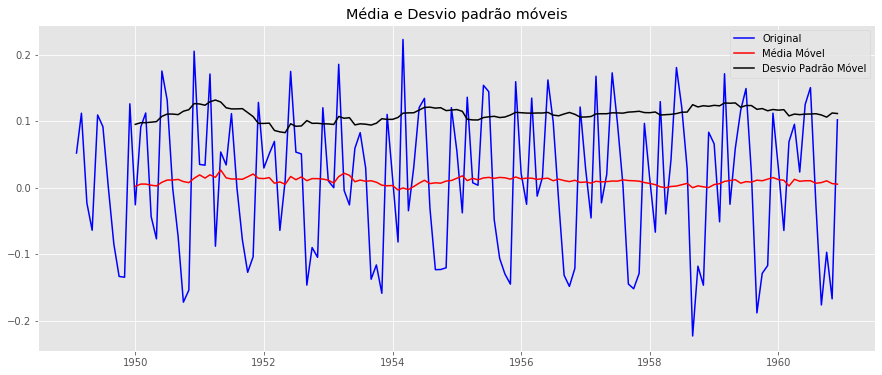

Resultados do teste Dickety-Fuller:
Teste Estatistico         -2.717131
p-value                    0.071121
#Lags Used                14.000000
Numero de observações    128.000000
Valor crítico (1%)        -3.482501
Valor crítico (5%)        -2.884398
Valor crítico (10%)       -2.578960
dtype: float64


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Podemos ver que a média e desvio padrão têm pequenas variações com o tempo. Além disso, a estatística de teste Dickey-Fuller é menor do que o valor crítico de 10%, assim a TS é estacionária com 90% de confiança. Nós também podemos ter diferenças de segunda ou terceira ordem que poderiam obter resultados ainda melhores em determinadas aplicações.

### Decomposição

Nesta abordagem, tanto tendência quanto sazonalidade são modeladas separadamente e a parte restante da série é devolvida.

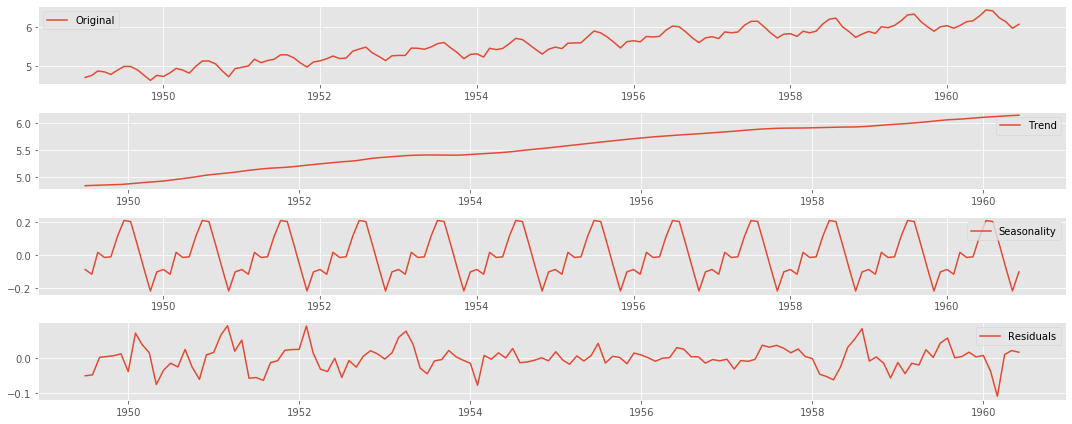

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
season = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(season, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()


Aqui podemos ver que a tendência e a sazonalidade são separadas  e podemos modelar os resíduos. Vamos verificar a estacionaridade dos resíduos:

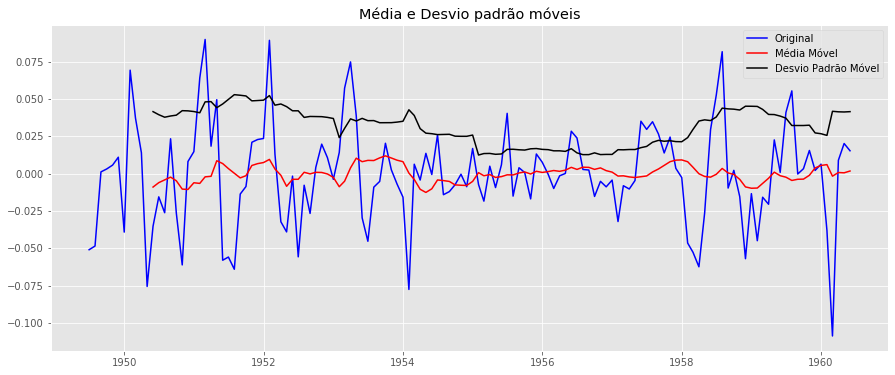

Resultados do teste Dickety-Fuller:
Teste Estatistico       -6.332387e+00
p-value                  2.885059e-08
#Lags Used               9.000000e+00
Numero de observações    1.220000e+02
Valor crítico (1%)      -3.485122e+00
Valor crítico (5%)      -2.885538e+00
Valor crítico (10%)     -2.579569e+00
dtype: float64


In [22]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

A estatística do teste Dickey-Fuller é significativamente menor do que o valor crítico de 1%. Portanto, essa TS é muito próxima a estacionária. Você pode tentar técnicas de decomposição avançadas, que podem gerar melhores resultados. Além disso, você deve observar que a conversão dos resíduos em valores originais para dados futuros não são muito intuitivas neste caso.

## Forecast de uma Série Temporal

Vimos técnicas diferentes e todos elas funcionaram razoavelmente bem para fazer a TS estacionária. Vamos fazer um modelo sobre A TS com a diferenciação, pois é uma técnica muito popular. Além disso, é relativamente mais fácil adicionar ruído e sazonalidade de volta aos resíduos previstos nesse caso. Tendo feito as técnicas de tendência e estimativa de sazonalidade, podem haver duas situações:

1- Uma série estritamente estacionária com nenhuma dependência entre os valores. Este é o caso fácil, em que podemos modelar os resíduos como sendo ‘white noise’. Mas isso é muito raro.

2- Uma série com dependência significativa entre os valores. Neste caso, precisamos usar alguns modelos estatísticos como ARIMA para prever os dados.

Deixe-me fazer uma breve introdução ao ARIMA. Não vou entrar em detalhes técnicos, mas você deve entender esses conceitos em detalhes se deseja aplicá-los de forma mais eficaz. ARIMA significa Médias Móveis Integradas e Auto-Regressivs (Auto-Regressive Integrated Moving Averages). A previsão ARIMA para uma série temporal estacionária é nada mais que uma equação linear (como uma regressão linear). Os preditores dependem dos parâmetros (p, d, q) do modelo ARIMA:

1- Número de termos AR (auto-regressivo) (p): termos AR são apenas defasagens da variável dependente. Por exemplo, se o símbolo p representa 5, os preditores de x(t) serão X(t-1) … .x(T-5).

2-  Número de termos MA (média móvel) (q): termos MA são erros de previsão defasados na equação de projeção. Por exemplo, se q é 5, os preditores para x(t) serão E(t-1) … .e(t-5) onde e(i) é a diferença entre a média móvel no instante i e o valor real.

3- Número de Diferenças (d): Estes são o número de diferenças não sazonais, ou seja, neste caso, tomamos a diferença de primeira ordem. Assim, ou nós podemos passar essa variável e colocar d = 0, ou passar a variável original e colocar d = 1. Ambos irão gerar mesmos resultados.
Uma preocupação importante aqui é como determinar o valor de ‘p’ e ‘q’. 

Usamos dois jeitos para determinar esses números. Vamos discuti-los primeiro.

1- Função de autocorrelação (ACF): É uma medida da correlação entre o TS com uma versão desfasada de si mesmo. Por exemplo, na lag 5, ACF iria comparar séries no instante de tempo ‘t1’ … ‘t2’ com a série no instante ‘T1-5’ … ‘t2-5’ (T1-5 e t2 sendo pontos finais).

2- Função de autocorrelação parcial (FACP): Esta mede a correlação entre o TS com uma versão desfasada de si mesmo, mas depois de eliminar as variações já explicadas pelas comparações intervenientes. Por exemplo, no lag 5, ele irá verificar a correlação, mas remover os efeitos já explicadas por defasagens 1 a 4.

As funções ACF e FACP para as TS após diferenciação podem ser plotados como:

In [23]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method='ols')

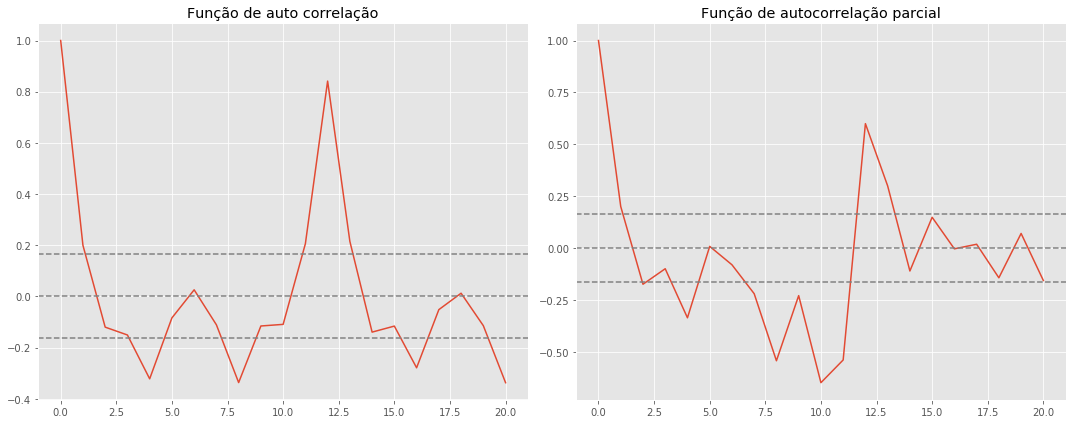

In [26]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Função de auto correlação')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Função de autocorrelação parcial')

plt.tight_layout()

Nesta plotagem, as duas linhas pontilhadas em ambos os lados de 0 são os interrvalos de confiança. Estes podem ser usados para determinar os valores ‘p’ e ‘q’ como:

1- p – O valor de atraso quando o gráfico PACF atravessa o intervalo de confiança superior pela primeira vez. Se você observar de perto, neste caso, p = 2.

2- q – O valor de atraso quando o gráfico ACF atravessa o intervalo de confiança superior pela primeira vez. Se você observar de perto, neste caso q = 2.

Agora, vamos fazer 3 modelos ARIMA diferentes, considerando efeitos individuais bem como efeitos combinados. Eu também irei imprimir o RSS para cada um. Por favor note que aqui RSS é para os valores de resíduos e não para série real.

In [27]:
from statsmodels.tsa.arima_model import ARIMA

Os valores p, d, q podem ser especificados usando o argumento de ordem de ARIMA que tomar uma tupla (p, d, q). Vamos modelar os 3 casos:

#### Modelo AR

C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

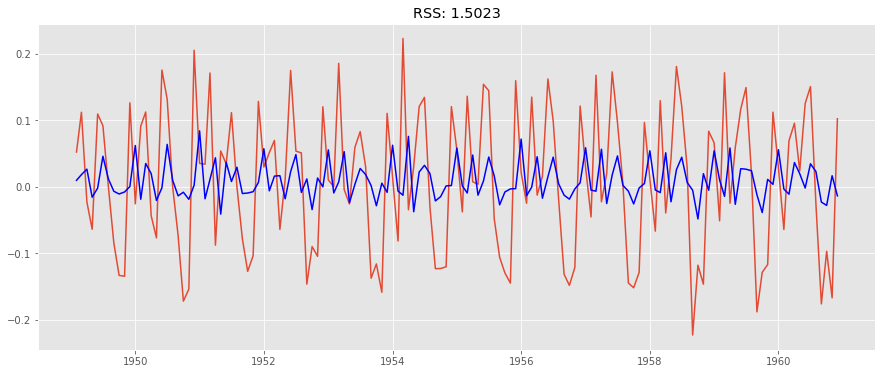

In [31]:
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)

plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues-ts_log_diff) ** 2))

#### Modelo MA

C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

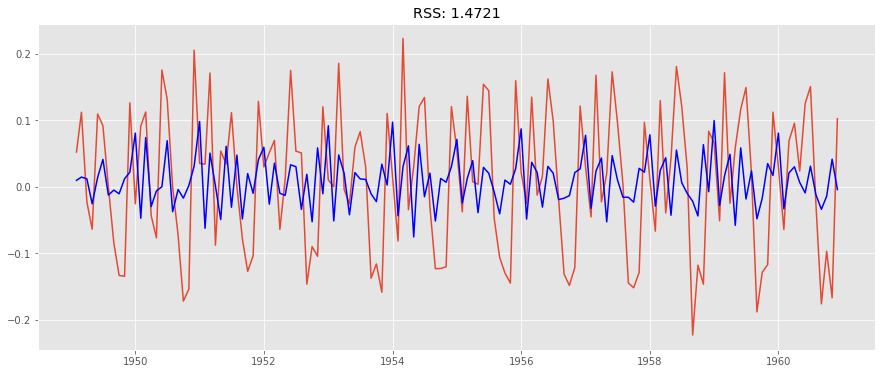

In [33]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#### Modelo combinado

C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guilherme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

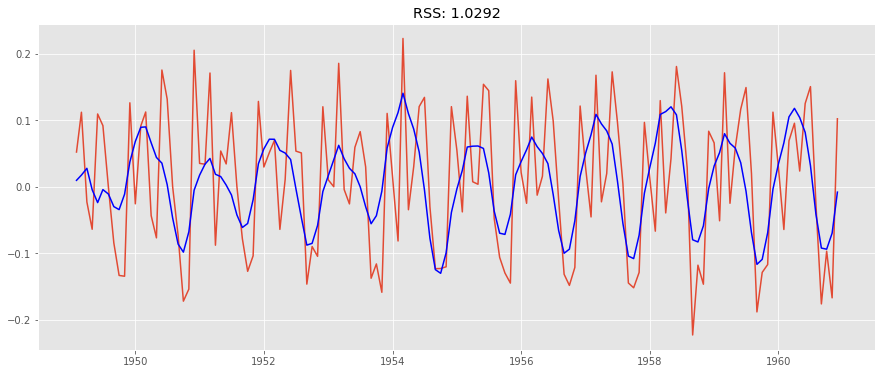

In [36]:
model = ARIMA(ts_log, order=(2, 1, 2)) 
results_ARIMA = model.fit(disp=-1) 
plt.plot(ts_log_diff) 
plt.plot(results_ARIMA.fittedvalues, color='blue') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff) ** 2))

Aqui podemos ver que os modelos AR e MA têm quase a mesma RSS, mas combinado é significativamente melhor. Agora, ficamos com um último passo, ou seja, trazer esses valores de volta para a escala original.

## Trazendo de volta à escala original

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True) 
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Observe que os resultados começam a partir de “1949/02/01”, e não do primeiro mês. Por que? Isto é porque nós tomamos o atraso por 1 e o primeiro elemento não tem nada antes de subtrair. A maneira de converter a diferenciação de escala logarítmica é adicionar essas diferenças consecutivamente ao número base. Uma maneira fácil de fazer isso é primeiro determinar a soma cumulativa no índice e, em seguida, adicioná-la ao número base. A soma cumulativa pode ser encontrada como:

In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() 
print (predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


Você pode rapidamente fazer algumas contas de cabeça usando a saída anterior para verificar se estão corretos. Em seguida temos que adicioná-los ao número base. Para isso, vamos criar uma série com todos os valores como número base e adicionar as diferenças a ela. Isto pode ser feito como:

In [47]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0) 
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Aqui, o primeiro elemento é o número base em si e a partir dele os valores cumulativamente somados. O último passo é tomar o expoente e comparar com a série original.



Text(0.5, 1.0, 'RMSE: 90.1046')

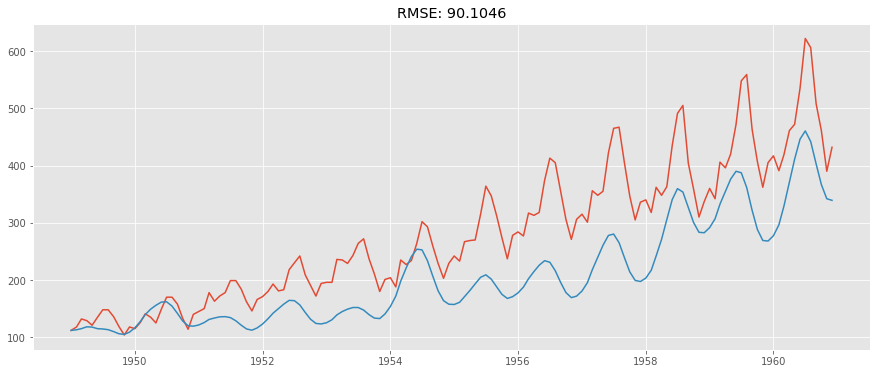

In [49]:
predictions_ARIMA = np.exp(predictions_ARIMA_log) 
plt.plot(ts)
plt.plot(predictions_ARIMA) 
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))